### Loading some required packages

In [1]:
using PyPlot

INFO: Loading help data...


# Initialising functions realted to the action values ground truth

Action values are draw from a Gaussian distribution with mean 0 and variance 1

In [2]:
draw_action_values(n::Int64) = [randn() for i=1:n]

#function draw_action_values(n::Int64)
#    return [randn() for i=1:n]
#end

draw_action_values (generic function with 1 method)

test draw_action_values function

In [3]:
Q_star = draw_action_values(10)

10-element Array{Float64,1}:
  1.41075 
  1.20798 
  1.16808 
 -0.193087
  0.943556
 -0.582327
 -0.119146
  1.19251 
 -1.0996  
 -0.948524

Action values are randomised by adding a value from a Gaussian distribution with mean 0 and variance 1 to it

In [4]:
randomise_action_value(value::Float64) = value + randn()

randomise_action_value (generic function with 1 method)

test randomisation of action values

In [5]:
for i = 1:10
    println(randomise_action_value(Q_star[1]))
end

1.5677692531333622
0.7668100780948003
-0.04352127166766562
0.7616685960153673
2.6264006710380787
0.9480145238331541
1.4378813881670596
0.0798872532542636
0.8438413924895455
-0.11854062802935816


# Function to evaluate exploration methods

In [6]:
function evaluate_method(method::Function, nr_of_actions::Int64, nr_of_plays::Int64, nr_of_trials::Int64)
    average_reward_per_action = zeros(nr_of_plays, nr_of_trials)
    percentage_of_best_action = zeros(nr_of_plays, nr_of_trials)
    for t = 1:nr_of_trials
        # draw Q^*(a) and sort it, so that action 1 is always the best
        Q_star = sort(draw_action_values(nr_of_actions), rev=true) # ground truth
        Q_est  = zeros(nr_of_actions) # estimated action-values
        Q_sum  = zeros(nr_of_actions) # sum of all rewards for each action
        k_a    = zeros(nr_of_actions) # counts of times action a was chosen
        for p = 1:nr_of_plays
            selected_action                = method(Q_est)
            k_a[selected_action]           = k_a[selected_action] + 1.0
            randomised_action_value        = Q_star[selected_action] + randn()
            Q_sum[selected_action]         = Q_sum[selected_action] + randomised_action_value
            Q_est[selected_action]         = Q_sum[selected_action] / k_a[selected_action]
            average_reward_per_action[p,t] = randomised_action_value
            percentage_of_best_action[p,t] = (selected_action == 1)?1:0
        end
    end
    return mean(average_reward_per_action,2), mean(percentage_of_best_action,2)
end

evaluate_method (generic function with 1 method)

# Greedy and ϵ-greedy functions

In [7]:
function ϵ_greedy(ϵ::Float64, Q::Vector{Float64})
    action = nothing
    if rand() >= ϵ || ϵ == 0.0
        # get the highest estimated value
        max_Q            = maximum(Q)
        # get the list of actions with the highest value
        possible_actions = findin(Q,max_Q)
        # chose randomly from the list of actions with the highest values
        action           = possible_actions[ceil(rand() * length(possible_actions))]
    else
        # chose randomly from all actions
        action = ceil(rand() * length(Q))
    end
    return action
end

ϵ_greedy (generic function with 1 method)

## Define greedy als 0-greedy function

In [8]:
greedy(Q::Vector{Float64}) = ϵ_greedy(0.0, Q);

## Evaluate greedy and ϵ-greedy functions

Generating the data

In [9]:
r_greedy,p_greedy=evaluate_method(greedy, 10, 1000, 2000);

ϵ_greedy_with_001(Q::Vector{Float64})=ϵ_greedy(0.01, Q)
r_ϵ_001,p_ϵ_001=evaluate_method(ϵ_greedy_with_001, 10, 1000, 2000);

ϵ_greedy_with_01(Q::Vector{Float64})=ϵ_greedy(0.1, Q)
r_ϵ_01,p_ϵ_01=evaluate_method(ϵ_greedy_with_01, 10, 1000, 2000);

Plotting the average reward per action

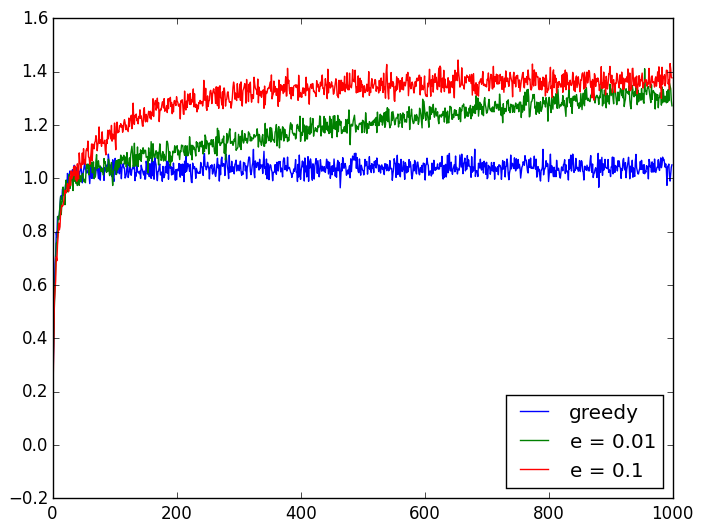

PyObject <matplotlib.legend.Legend object at 0x1164deb50>

In [10]:
pg    = plot(r_greedy)
p_001 = plot(r_ϵ_001)
p_01  = plot(r_ϵ_01)
legend( [pg,p_001,p_01], ["greedy", "e = 0.01", "e = 0.1"], loc=4)

Plotting how often the correct actions was chosen on average

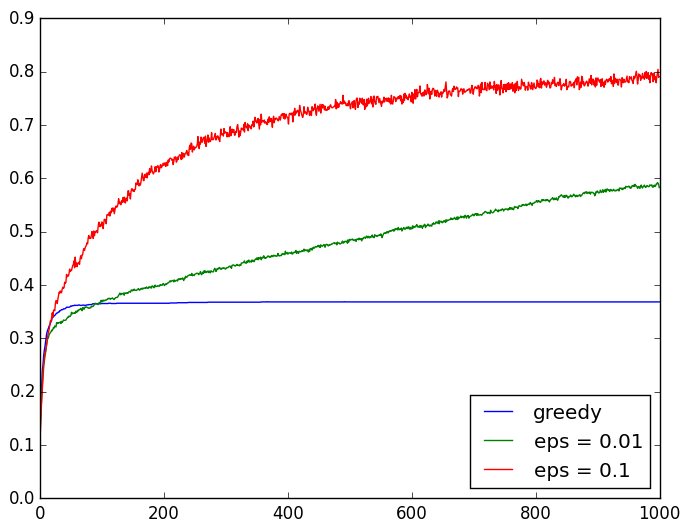

PyObject <matplotlib.legend.Legend object at 0x10604a3d0>

In [11]:
pg    = plot(p_greedy)
p_001 = plot(p_ϵ_001)
p_01  = plot(p_ϵ_01)
legend( [pg,p_001,p_01], ["greedy", "eps = 0.01", "eps = 0.1"], loc=4)

# Softmax

In [12]:
function softmax(tau::Float64, Q::Vector{Float64})
    probabilities = [exp(Q[a] / tau) for a=1:length(Q)]
    s             = sum(probabilities)
    probabilities = probabilities ./ s
    p  = rand()
    pa = 0
    for a = 1:length(Q)
        pa = pa + probabilities[a]
        if p < pa
            return a
        end
    end
    return length(Q)
end

softmax (generic function with 1 method)

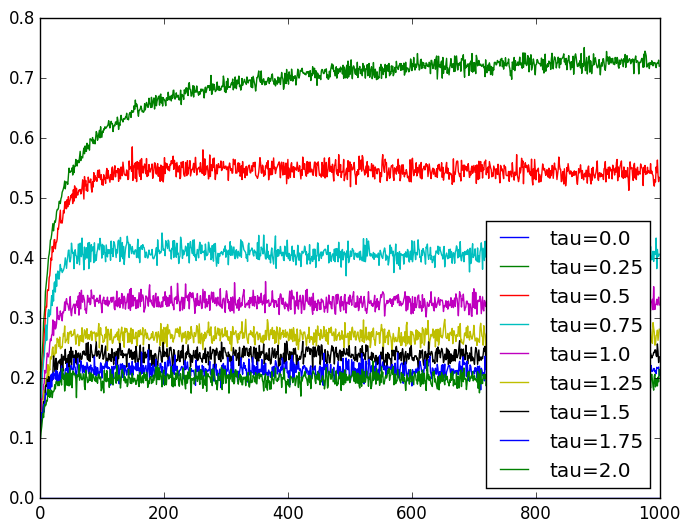

PyObject <matplotlib.legend.Legend object at 0x11abf3690>

In [13]:
l = []
plots = []

for t in [0:0.25:2]
    softmax_func(Q::Vector{Float64}) = softmax(t, Q)
    a_softmax,p_softmax=evaluate_method(softmax_func, 10, 1000, 2000)
    p = plot(p_softmax)
    plots = [plots, p]
    l = [l, "tau=$t"]
end

legend(plots, l, loc=4)

# Optimistic initial values

In [14]:
function evaluate_optimistic_method(method::Function, nr_of_actions::Int64, nr_of_plays::Int64, nr_of_trials::Int64, Q_init::Float64)
    average_reward_per_action = zeros(nr_of_plays, nr_of_trials)
    percentage_of_best_action = zeros(nr_of_plays, nr_of_trials)
    for t = 1:nr_of_trials
        # draw Q^*(a) and sort it, so that action 1 is always the best
        Q_star = sort(draw_action_values(nr_of_actions), rev=true) # ground truth
        Q_est  = ones(nr_of_actions) .* Q_init # estimated action-values
        Q_sum  = zeros(nr_of_actions) # sum of all rewards for each action
        k_a    = zeros(nr_of_actions) # counts of times action a was chosen
        for p = 1:nr_of_plays
            selected_action = method(Q_est)
            k_a[selected_action]   = k_a[selected_action] + 1.0
            randomised_action_value = Q_star[selected_action] + randn()
            Q_sum[selected_action] = Q_sum[selected_action] + randomised_action_value
            Q_est[selected_action] = Q_sum[selected_action] / k_a[selected_action]
            average_reward_per_action[p,t] = randomised_action_value
            percentage_of_best_action[p,t] = (selected_action == 1)?1:0
        end
    end
    return mean(average_reward_per_action,2), mean(percentage_of_best_action,2)
end

evaluate_optimistic_method (generic function with 1 method)

In [15]:
r_greedy_optimisitic,p_greedy_optimisitic=evaluate_optimistic_method(greedy, 10, 1000, 2000, 5.0);

ϵ_greedy_with_001(Q::Vector{Float64})=ϵ_greedy(0.01, Q)
r_ϵ_001_optimisitic,p_ϵ_001_optimisitic=evaluate_optimistic_method(ϵ_greedy_with_001, 10, 1000, 2000, 5.0);

ϵ_greedy_with_01(Q::Vector{Float64})=ϵ_greedy(0.1, Q)
r_ϵ_01_optimisitic,p_ϵ_01_optimisitic=evaluate_optimistic_method(ϵ_greedy_with_01, 10, 1000, 2000, 5.0);

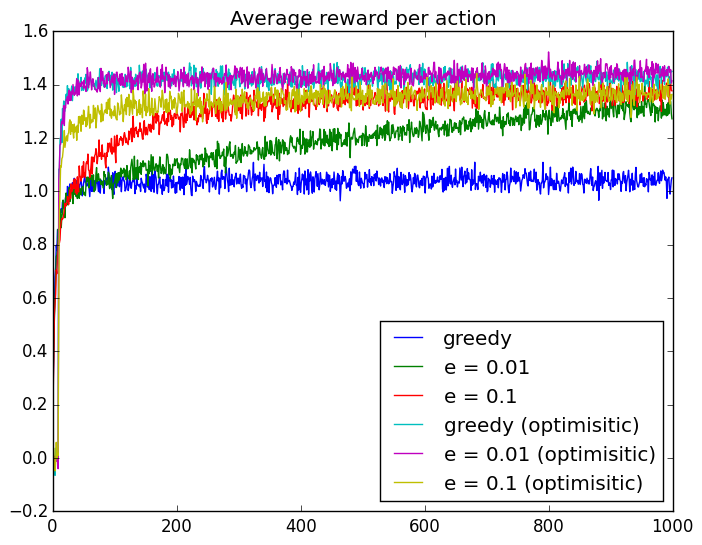

PyObject <matplotlib.text.Text object at 0x11ae21b10>

In [16]:
pg    = plot(r_greedy)
p_001 = plot(r_ϵ_001)
p_01  = plot(r_ϵ_01)

pg_opt    = plot(r_greedy_optimisitic)
p_001_opt = plot(r_ϵ_001_optimisitic)
p_01_opt  = plot(r_ϵ_01_optimisitic)

legend( [pg, p_001, p_01, pg_opt, p_001_opt, p_01_opt], ["greedy", "e = 0.01", "e = 0.1","greedy (optimisitic)", "e = 0.01 (optimisitic)", "e = 0.1 (optimisitic)"], loc=4)
title("Average reward per action")

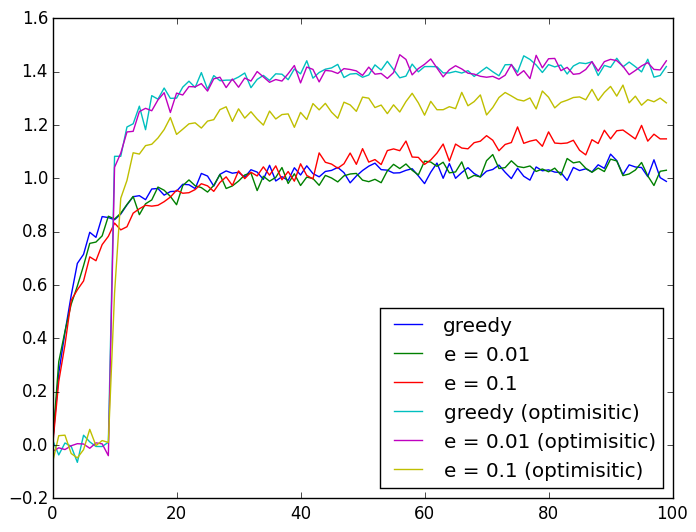

PyObject <matplotlib.legend.Legend object at 0x11b12fa10>

In [17]:
pg    = plot(r_greedy[1:100])
p_001 = plot(r_ϵ_001[1:100])
p_01  = plot(r_ϵ_01[1:100])

pg_opt    = plot(r_greedy_optimisitic[1:100])
p_001_opt = plot(r_ϵ_001_optimisitic[1:100])
p_01_opt  = plot(r_ϵ_01_optimisitic[1:100])

legend( [pg, p_001, p_01, pg_opt, p_001_opt, p_01_opt], ["greedy", "e = 0.01", "e = 0.1","greedy (optimisitic)", "e = 0.01 (optimisitic)", "e = 0.1 (optimisitic)"], loc=4)

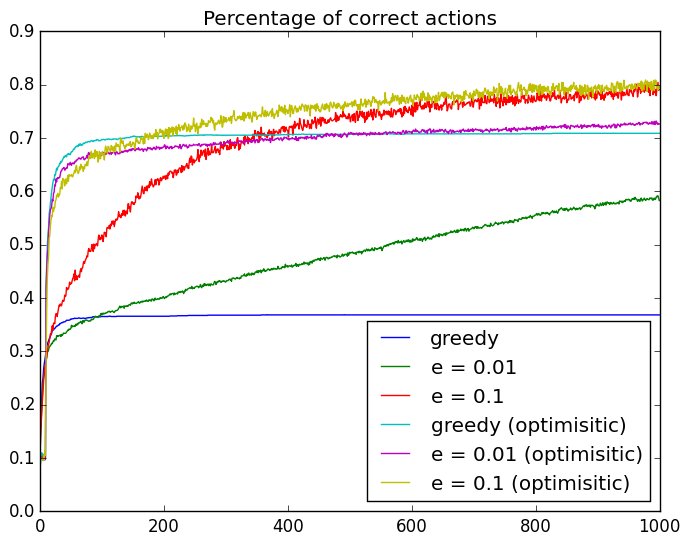

PyObject <matplotlib.text.Text object at 0x11b091d50>

In [18]:
pg    = plot(p_greedy)
p_001 = plot(p_ϵ_001)
p_01  = plot(p_ϵ_01)

pg_opt    = plot(p_greedy_optimisitic)
p_001_opt = plot(p_ϵ_001_optimisitic)
p_01_opt  = plot(p_ϵ_01_optimisitic)

legend( [pg, p_001, p_01, pg_opt, p_001_opt, p_01_opt], ["greedy", "e = 0.01", "e = 0.1","greedy (optimisitic)", "e = 0.01 (optimisitic)", "e = 0.1 (optimisitic)"], loc=4)
title("Percentage of correct actions")

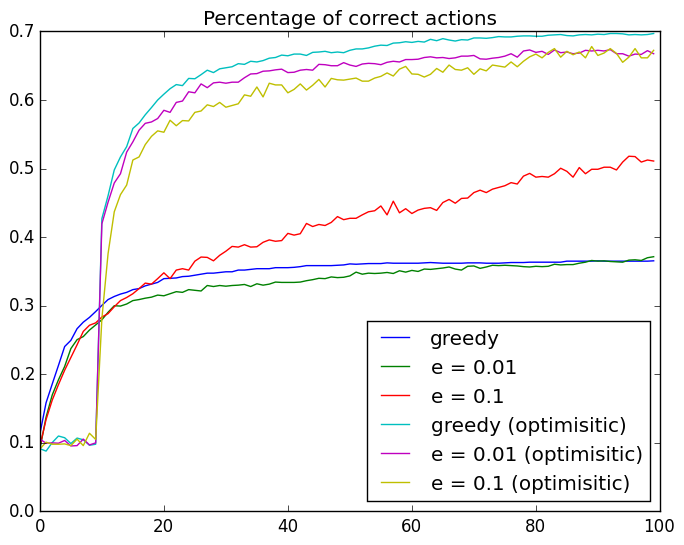

PyObject <matplotlib.text.Text object at 0x11b3dde10>

In [19]:
pg    = plot(p_greedy[1:100])
p_001 = plot(p_ϵ_001[1:100])
p_01  = plot(p_ϵ_01[1:100])

pg_opt    = plot(p_greedy_optimisitic[1:100])
p_001_opt = plot(p_ϵ_001_optimisitic[1:100])
p_01_opt  = plot(p_ϵ_01_optimisitic[1:100])

legend( [pg, p_001, p_01, pg_opt, p_001_opt, p_01_opt], ["greedy", "e = 0.01", "e = 0.1","greedy (optimisitic)", "e = 0.01 (optimisitic)", "e = 0.1 (optimisitic)"], loc=4);
title("Percentage of correct actions")

# Reinforcement comparison

In [20]:
function reinforcement_comparision(p::Vector{Float64})
    probabilities = [exp(p[a]) for a=1:length(p)]
    s             = sum(probabilities)
    probabilities = probabilities ./ s
    pr  = rand()
    pa = 0
    for a = 1:length(pr)
        pa = pa + probabilities[a]
        if pr < pa
            return a
        end
    end
    return length(p)
end

function evaluate_reinforcement_comparision(nr_of_actions::Int64, nr_of_plays::Int64, nr_of_trials::Int64, α::Float64, β::Float64)
    average_reward_per_action = zeros(nr_of_plays, nr_of_trials)
    percentage_of_best_action = zeros(nr_of_plays, nr_of_trials)
    for t = 1:nr_of_trials
        # draw Q^*(a) and sort it, so that action 1 is always the best
        Q_star   = sort(draw_action_values(nr_of_actions), rev=true) # ground truth
        Q_est    = zeros(nr_of_actions) # estimated action-values
        Q_sum    = zeros(nr_of_actions) # sum of all rewards for each action
        k_a      = zeros(nr_of_actions) # counts of times action a was chosen
        pa       = zeros(nr_of_actions)
        baseline = 0
        for p = 1:nr_of_plays
            selected_action                = reinforcement_comparision(pa)
            k_a[selected_action]           = k_a[selected_action] + 1.0
            randomised_action_value        = Q_star[selected_action] + randn()
            pa[selected_action]            = pa[selected_action] + β * (randomised_action_value - baseline)
            baseline                       = baseline + α * (randomised_action_value - baseline)
            Q_sum[selected_action]         = Q_sum[selected_action] + randomised_action_value
            Q_est[selected_action]         = Q_sum[selected_action] / k_a[selected_action]
            average_reward_per_action[p,t] = randomised_action_value
            percentage_of_best_action[p,t] = (selected_action == 1)?1:0
        end
    end
    return mean(average_reward_per_action,2), mean(percentage_of_best_action,2)
end;

In [21]:
r,p = evaluate_reinforcement_comparision(10, 1000, 2000, 0.1, 0.1);

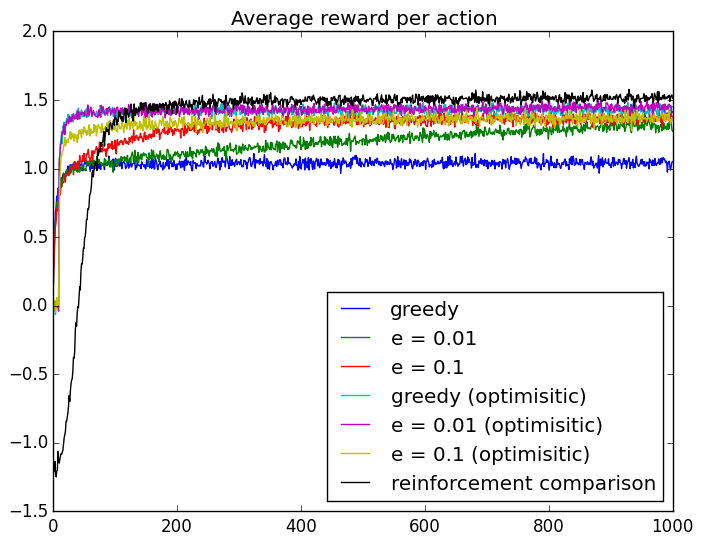

In [22]:
pg    = plot(r_greedy)
p_001 = plot(r_ϵ_001)
p_01  = plot(r_ϵ_01)

pg_opt    = plot(r_greedy_optimisitic)
p_001_opt = plot(r_ϵ_001_optimisitic)
p_01_opt  = plot(r_ϵ_01_optimisitic)

prc = plot(r)

legend( [pg, p_001, p_01, pg_opt, p_001_opt, p_01_opt, prc], ["greedy", "e = 0.01", "e = 0.1","greedy (optimisitic)", "e = 0.01 (optimisitic)", "e = 0.1 (optimisitic)", "reinforcement comparison"], loc=4)
title("Average reward per action");

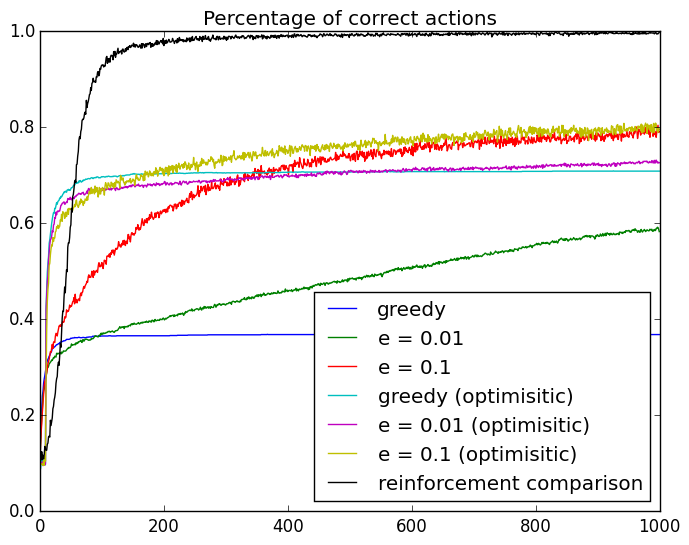

PyObject <matplotlib.text.Text object at 0x11baa6390>

In [23]:
pg    = plot(p_greedy)
p_001 = plot(p_ϵ_001)
p_01  = plot(p_ϵ_01)

pg_opt    = plot(p_greedy_optimisitic)
p_001_opt = plot(p_ϵ_001_optimisitic)
p_01_opt  = plot(p_ϵ_01_optimisitic)

prc = plot(p)

legend( [pg, p_001, p_01, pg_opt, p_001_opt, p_01_opt, prc], ["greedy", "e = 0.01", "e = 0.1","greedy (optimisitic)", "e = 0.01 (optimisitic)", "e = 0.1 (optimisitic)", "reinforcement comparison"], loc=4);
title("Percentage of correct actions")

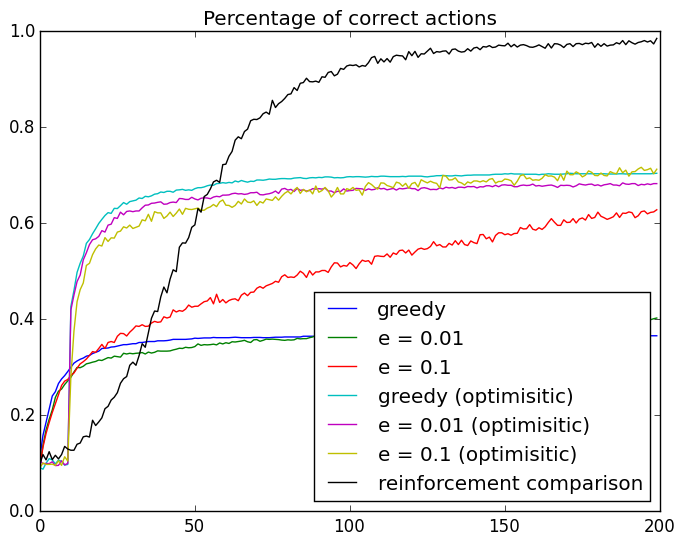

PyObject <matplotlib.text.Text object at 0x11bd0e650>

In [24]:
pg    = plot(p_greedy[1:200])
p_001 = plot(p_ϵ_001[1:200])
p_01  = plot(p_ϵ_01[1:200])

pg_opt    = plot(p_greedy_optimisitic[1:200])
p_001_opt = plot(p_ϵ_001_optimisitic[1:200])
p_01_opt  = plot(p_ϵ_01_optimisitic[1:200])

prc = plot(p[1:200])

legend( [pg, p_001, p_01, pg_opt, p_001_opt, p_01_opt, prc], ["greedy", "e = 0.01", "e = 0.1","greedy (optimisitic)", "e = 0.01 (optimisitic)", "e = 0.1 (optimisitic)", "reinforcement comparison"], loc=4);
title("Percentage of correct actions")